# 06_WalkingTime_to_BusRapidTransit

We investigate travel time from each building to City of Cape Town Bus Rapid Transit (MyCiTi) stations. We focus on the City Center and surrounds and assume a building is were citizens live and work.

<div class="alert alert-block alert-warning"><b>DATA:</b></div>

> Our data comes from the [City Cape Town Open Data](https://odp.capetown.gov.za/)

In [1]:
#load the magic
%matplotlib inline
import os
from pathlib import Path
import warnings

import pandana as pdna

import time
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
#set path
path = Path('./')

<div class="alert alert-block alert-info"><b>Fetch Data:</b> We harvest data directly via API</div>

In [3]:
#load subcouncils ~ subcouncils provide a general region to clip other data too
sub_object = 'https://citymaps.capetown.gov.za/agsext1/rest/services/Theme_Based/Open_Data_Service/MapServer/77/query?where=1%3D1&outFields=OBJECTID,SUB_CNCL_NAME&outSR=4326&f=json'
sub_shp = gpd.read_file(sub_object)
sub_shp = sub_shp.set_crs(epsg=4326)

#set subcouncil 16 as mask 
sub16_shp = sub_shp[sub_shp['OBJECTID'] == 11].copy()
mask = sub16_shp

#load myciti stops ~ clipped to mask 
myciST_object = 'https://citymaps.capetown.gov.za/agsext1/rest/services/Theme_Based/Open_Data_Service/MapServer/96/query?where=1%3D1&outFields=OBJECTID,NAME&outSR=4326&f=json'
myciST_shp = gpd.read_file(myciST_object, mask=mask)
myciST_shp = myciST_shp.set_crs(epsg=4326)

#load suburbs
ofsub_object = 'https://citymaps.capetown.gov.za/agsext1/rest/services/Theme_Based/Open_Data_Service/MapServer/75/query?where=1%3D1&outFields=OBJECTID,OFC_SBRB_NAME&outSR=4326&f=json'
ofsub_shp = gpd.read_file(ofsub_object)
ofsub_shp = ofsub_shp.set_crs(epsg=4326)

In [4]:
#select suburbs
sub_ofsub_shp = ofsub_shp.loc[ofsub_shp['OFC_SBRB_NAME'].isin(['CAMPS BAY / BAKOVEN' , 'CLIFTON',
                                                               'BANTRY BAY',  'SEA POINT',  'THREE ANCHOR BAY',
                                                               'MOUILLE POINT','FORESHORE', 'GREEN POINT', 
                                                               'SIGNAL HILL / LIONS HEAD', 'TAMBOERSKLOOF',
                                                               'BO-KAAP', 'CAPE TOWN CITY CENTRE', 'GARDENS', 
                                                               'ORANJEZICHT', 'VREDEHOEK',
                                                               'DISTRICT SIX'])].copy()

In [5]:
#suburbs
sub_ofsub_shp.head(3)

,OBJECTID,OFC_SBRB_NAME,geometry
36,37,BO-KAAP,"POLYGON ((18.41289 -33.91609, 18.41290 -33.916..."
73,74,MOUILLE POINT,"POLYGON ((18.41250 -33.89901, 18.41272 -33.899..."
82,83,TAMBOERSKLOOF,"POLYGON ((18.40530 -33.92410, 18.40536 -33.924..."


In [6]:
#subcouncil
sub16_shp.head(3)

,OBJECTID,SUB_CNCL_NAME,geometry
10,11,Subcouncil 16,"MULTIPOLYGON (((18.43449 -33.89763, 18.43449 -..."


In [7]:
#myciti stops
myciST_shp.head(4)

,OBJECTID,NAME,geometry
0,32,Boat Bay,POINT (18.38676 -33.91602)
1,241,Quebec,POINT (18.38373 -33.95260)
2,263,Ravensteyn,POINT (18.38491 -33.95718)
3,264,Camps Bay,POINT (18.37884 -33.95001)


<div class="alert alert-block alert-info"><b>Building Data:</b> experienced challenges harvesting building footprint dataset. Loaded locally.</div>

In [8]:
#load building footprints
buil_object = path/'data/2D_Basic_Footprint.shp'
build_shp = gpd.read_file(buil_object, mask=mask)
sub_build_shp = build_shp.set_crs(epsg=4326)

#### Have a look and focus on the cbd

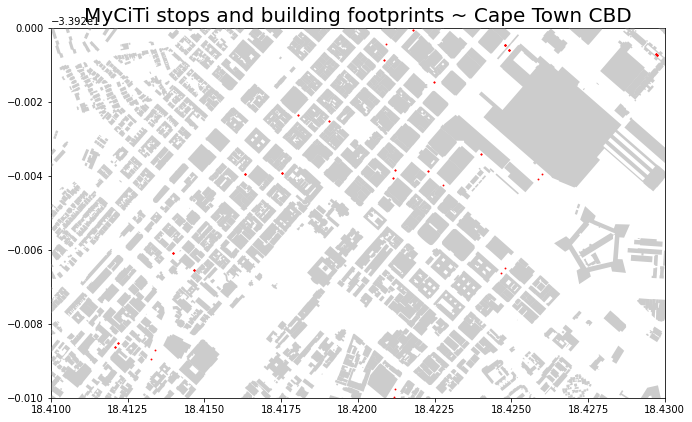

In [9]:
#plot
fig, ax = plt.subplots(figsize=(11,11))

#ax.axis([18.307449, 18.486628, -34.06159, -33.78957])
ax.axis([18.41, 18.43, -33.93, -33.92]) # cpt ~ cbd

#sub_shp.boundary.plot(ax=ax, zorder=1)
sub_build_shp.plot(ax=ax, zorder=4, color='grey', alpha = 0.4)#, alpha=0.8)
myciST_shp.plot(ax=ax, marker='.', color='r', zorder=3, markersize=3)

plt.title('MyCiTi stops and building footprints ~ Cape Town CBD', size=20)

plt.show()

#### `pandana` deals in `x` and `y Point` geometries. We extract the values we need from the data we have.

In [10]:
#get x,y coords of the building centers
sub_build_shp['x'] = sub_build_shp['geometry'].centroid.x
sub_build_shp['y'] = sub_build_shp['geometry'].centroid.y

#get x,y coords of the mycity geometry
myciST_shp['x'] = myciST_shp['geometry'].x
myciST_shp['y'] = myciST_shp['geometry'].y

C:\Users\EstelleSK\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  
C:\Users\EstelleSK\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  This is separate from the ipykernel package so we can avoid doing imports until


<div class="alert alert-block alert-info">
<b>Load osm:</b> Read the previously saved osm streets and build the network</div>

In [11]:
%%time
#load the osm streets
net_filename = path/'data/osm2Way_network_CPT_walk.h5'

osm_walk_nodes = pd.HDFStore(net_filename).nodes
osm_walk_edges = pd.HDFStore(net_filename).edges

Wall time: 12.2 s


In [12]:
%%time
# build the network
network = pdna.Network(osm_walk_nodes["x"],
                       osm_walk_nodes["y"], 
                       osm_walk_edges["from"], 
                       osm_walk_edges["to"],
                       osm_walk_edges[["distance"]],
                       twoway=True)
print('Network initialized')

Network initialized
Wall time: 22.7 s


#### Set the MyCiTi stations and Buildings to the street network

~ we get the osm `node_id` for every building and MyCiTi stop and calculate a *nearest neighbor* to the 2 closest bus stops within a 1200m distance.

In [13]:
#get osm node_ids for the mycity stops
x, y = myciST_shp.x, myciST_shp.y 
myciST_shp["node_ids"] = network.get_node_ids(x, y)
network.set(myciST_shp["node_ids"], name="myciti_stop")

#get osm node_ids for the buildings
x, y = sub_build_shp.x, sub_build_shp.y
sub_build_shp["node_ids"] = network.get_node_ids(x, y)

In [14]:
#set some parameters
n=2
maxdistance = 1200

In [15]:
#set the myciti stops to the osm network and calculate nearest neighbor (two)
network.set_pois("myciti_stop", maxdistance , n, myciST_shp.x, myciST_shp.y)
stop_walk_distances = network.nearest_pois(maxdistance , "myciti_stop", num_pois=n, include_poi_ids=False)

In [16]:
stop_walk_distances.tail(3)

,1,2
id,,
8274520658,98.350998,98.350998
8274520664,167.087997,167.087997
8274520668,142.578003,142.578003


In [17]:
# Rename columns 0 to 1 to d_d_mycitiStop_0 to d_d_mycitiStop_1.
n=2
columns =  ['d_mycitiStop_'+str(i) for i in range(0, n, 1)]
stop_walk_distances.columns = columns

<div class="alert alert-block alert-info">
<b>Buildings to MyCiTi stop</b></div>

We match the osm `node_id` and transfer the *nearest neighbor* distance so the buildings now have a distance to the closest MyCiTi stop.

In [18]:
#match the osm node_ids and calculate distance from building to mycity stop 
for i in range(2):
    sub_build_shp['d_mycitiStop_{}'.format(i)] = sub_build_shp['node_ids'].map(stop_walk_distances['d_mycitiStop_{}'.format(i)])

In [130]:
#sub_build_shp.head(3)

,OBJECTID,ACQS_SRC,ACQS_PRD,SHAPE_Leng,SHAPE_Area,geometry,x,y,node_ids,d_mycitiStop_0,d_mycitiStop_1
0,1,Photogrammetry,201312,73.776666,212.488504,"POLYGON ((18.40213 -33.90883, 18.40213 -33.908...",18.402044,-33.908884,33891928,129.070007,129.070007
1,2,Photogrammetry,201312,11.811172,8.623701,"POLYGON ((18.40196 -33.90884, 18.40192 -33.908...",18.401938,-33.908827,33891928,129.070007,129.070007
2,3,Photogrammetry,201312,71.706506,213.231710,"POLYGON ((18.40145 -33.90910, 18.40146 -33.909...",18.401400,-33.909189,33891927,224.735001,224.735001


<div class="alert alert-block alert-warning"><b>TIME:</b></div>

We add time columns through simply ~
           
              minutes = ((distance in m / conversion to miles / walking speed in miles)*60

In [19]:
# add a time column
# Calculate time ~ minutes ~ based on distances    ((distance/1609)/speed)*60)
sub_build_shp['m_mycitiStop_0'] = sub_build_shp.apply(lambda row: ((row.d_mycitiStop_0/1609)/3)*60, axis=1)
sub_build_shp['m_mycitiStop_1'] = sub_build_shp.apply(lambda row: ((row.d_mycitiStop_1/1609)/3)*60, axis=1)

C:\Users\EstelleSK\Anaconda3\lib\site-packages\mapclassify\classifiers.py:237: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
C:\Users\EstelleSK\Anaconda3\lib\site-packages\mapclassify\classifiers.py:239: UserWarning: Warning: setting k to 4
  Warn("Warning: setting k to %d" % k_q, UserWarning)


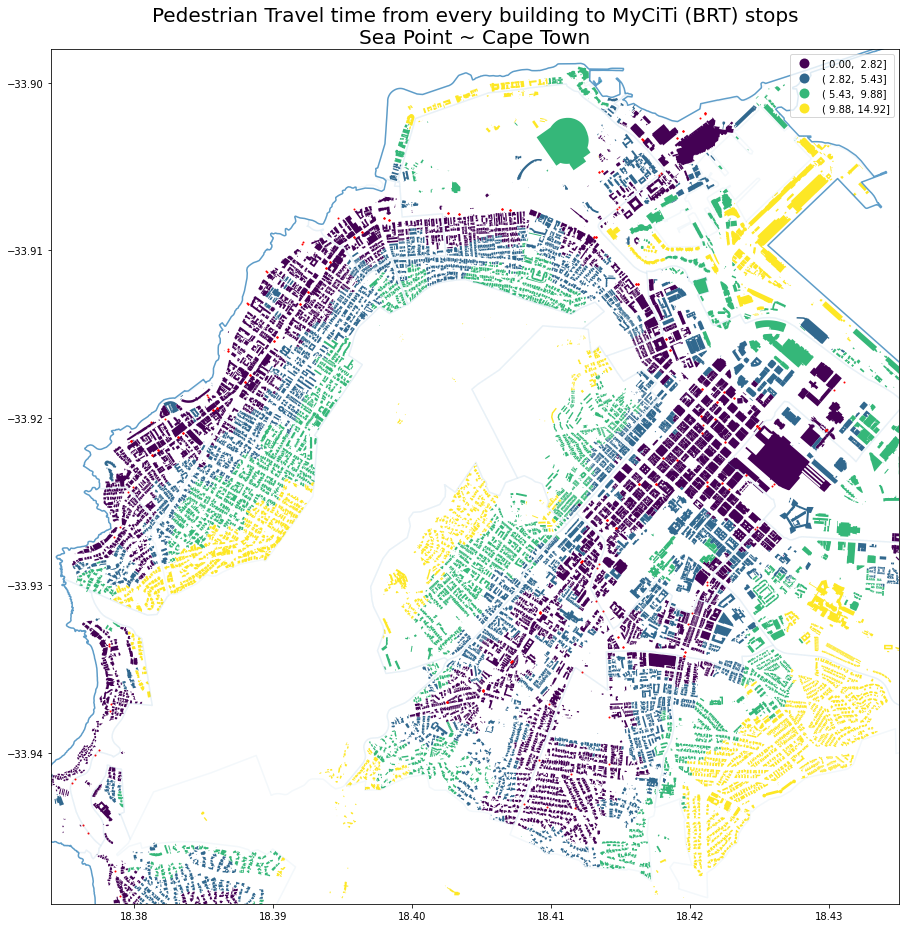

In [21]:
# plot
ax = sub_build_shp.plot(figsize=(13, 13), column='m_mycitiStop_0', 
                        scheme='quantiles', legend=True, markersize = 1)

myciST_shp.plot(ax=ax, color='red', markersize = 1)
sub_shp.boundary.plot(ax=ax, zorder=1, alpha=0.7)
sub_ofsub_shp.boundary.plot(ax=ax, zorder=2, alpha=0.05, marker='--')

plt.axis([18.374, 18.435, -33.949, -33.898])
plt.title('Pedestrian Travel time from every building to MyCiTi (BRT) stops\nSea Point ~ Cape Town', size=20)
plt.tight_layout()
plt.show()

#### We can compare Suburbs

> What is the average walking time from each building to a MyCiTi stop per suburb?

In [22]:
# sjoin where Suburbs are intersected with buildings
sub_address = gpd.sjoin(sub_ofsub_shp, sub_build_shp, op='intersects', how='left')

In [23]:
#count buildings per suburb
sub_address.OFC_SBRB_NAME.value_counts()

CAMPS BAY / BAKOVEN         2661
GARDENS                     2255
SEA POINT                   1979
VREDEHOEK                   1888
GREEN POINT                 1660
ORANJEZICHT                 1266
CAPE TOWN CITY CENTRE       1108
TAMBOERSKLOOF               1094
BO-KAAP                      983
DISTRICT SIX                 880
FORESHORE                    689
BANTRY BAY                   446
THREE ANCHOR BAY             343
CLIFTON                      294
SIGNAL HILL / LIONS HEAD      95
MOUILLE POINT                 88
Name: OFC_SBRB_NAME, dtype: int64

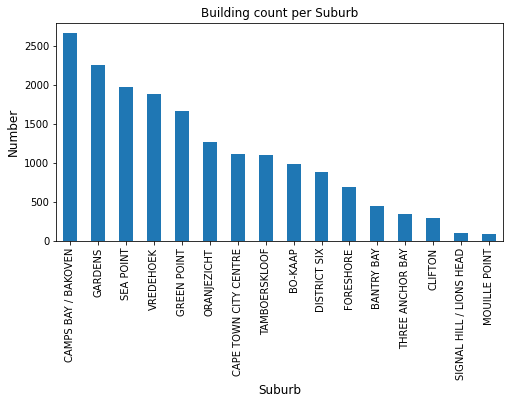

In [24]:
#plot
plt.figure(figsize=(8,4))

plt.title("Building count per Suburb")
plt.ylabel('Number', fontsize=12)
plt.xlabel('Suburb', fontsize=12)

sub_address.OFC_SBRB_NAME.value_counts().plot.bar()

plt.show()

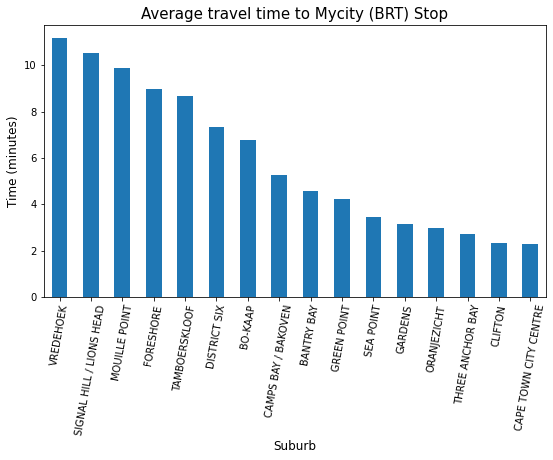

In [25]:
# bar plot
plt.figure(figsize=(9,5))
sub_address_bar = sub_address.groupby(['OFC_SBRB_NAME'])['m_mycitiStop_0'].mean()

sub_address_bar.sort_values(ascending=False).plot.bar()

plt.title("Average travel time to Mycity (BRT) Stop", size=15)
plt.ylabel('Time (minutes)', fontsize=12)
plt.xlabel('Suburb', fontsize=12)
plt.tick_params(axis='x', labelrotation=80)

plt.show()

#### Lets focus on one suburb

In [26]:
# Get bounding box coordinates and area name for a particular suburb
# Pick index number from the suburbs
minx, miny, maxx, maxy = sub_ofsub_shp.bounds.iloc[7].values
# Pick the same index number from the list above and place it in the [] to get the area name 
area_name = sub_ofsub_shp.OFC_SBRB_NAME.iloc[7]
area_name

'GARDENS'

C:\Users\EstelleSK\Anaconda3\lib\site-packages\mapclassify\classifiers.py:237: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
C:\Users\EstelleSK\Anaconda3\lib\site-packages\mapclassify\classifiers.py:239: UserWarning: Warning: setting k to 4
  Warn("Warning: setting k to %d" % k_q, UserWarning)


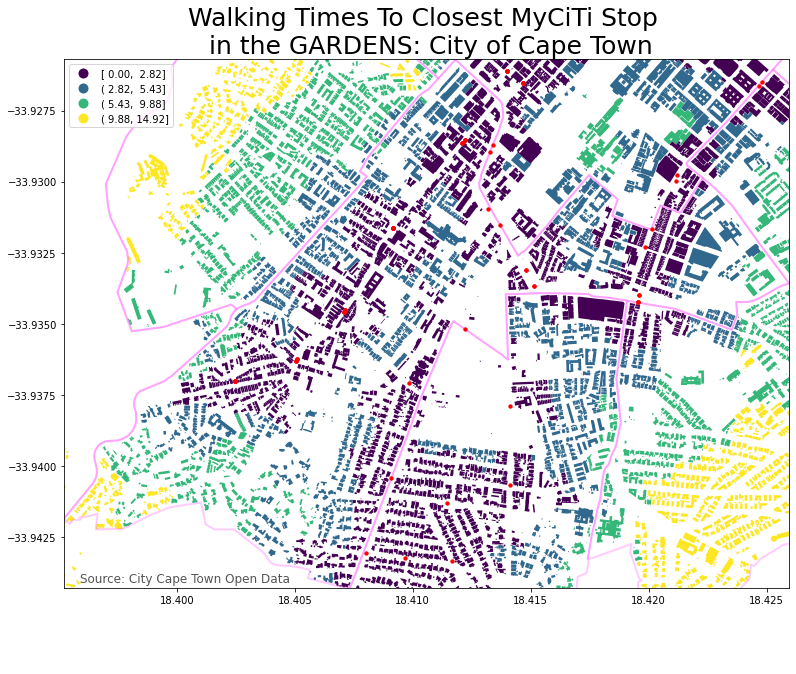

In [37]:
### plot
ax = sub_build_shp.plot(figsize=(13, 13), column='m_mycitiStop_0', scheme='quantiles', 
                        legend=True, markersize = 4)
sub_ofsub_shp.plot(ax=ax, facecolor='none', edgecolor='magenta', alpha= 0.2, linewidth=2)
myciST_shp.plot(ax=ax, color='red', markersize =11)

# limits
ax.set(xlim=(minx, maxx), ylim=(miny, maxy))

# add a title
ax.set_title((('Walking Times To Closest MyCiTi Stop \n in the {0}: City of Cape Town').format(area_name)), 
             fontdict={'fontsize': '25', 'fontweight' : '3'})
# create an annotation for the data source
ax.annotate('Source: City Cape Town Open Data',xy=(0.1, 0.15),  xycoords='figure fraction', 
            horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

# to save figure
#plt.savefig(path/'data/MyCiTi-Gardens_walkability.png', dpi=300)
plt.show()